# **Monkey Species Classification**



### **Context:**
Several species of monkeys have become extinct in recent years. As a result, a wildlife sanctuary in the United States has taken an important step forward in gathering data on all species that are currently endangered. They have collected images of monkeys from several continents. However, it has become difficult for them to organize all of these images into their respective categories. They require a solution to identify these images into their relevant monkey species groups. As a data scientist, you have to create an efficient model to classify these images into their respective categories.

### **Objective:**

Building a Convolutional Neural Network model to classify the monkey species into their respective categories.

### **Data Description:**

This dataset is taken from Kaggle and it consists of the various species of monkeys.
-  Due to the large volume of data, the images were converted to the images.npy file and the labels are also placed in Labels.csv, allowing you to work on the data without being concerned about the large data volume.
- The dataset comprises of 10 monkey species.

**List of Species**
- Mantled Howler
- Patas Monkey
- Bald Monkey
- Japanese Macaque
- Pygmy Marmoset
- White Headed Capuchin
- Silver Marmosetr
- Common Squirrel Monkey
- Black Headed Night Monkey
- Nilgiri Langur



####**Note: Please use GPU runtime to execute the code efficiently**






In [1]:
#pip install --upgrade pip

In [2]:
#pip install --upgrade tensorflow


In [3]:
#pip install --upgrade keras


## **Importing the necessary libraries**

In [4]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## **Reading the dataset**

In [5]:
# Mount Google drive to access the dataset (monkeys_dataset.zip)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Load the image file of the dataset
images = np.load("/content/drive/MyDrive/Nigerians Projects/Daniel Obioma/images (6).npy")

# Load the labels file of the dataset
labels = pd.read_csv("/content/drive/MyDrive/Nigerians Projects/Daniel Obioma/Labels (5).csv")

## **Overview of the dataset**


Let's print the shape of the images and labels

In [7]:
print(images.shape)
print(labels.shape)

(1342, 128, 128, 3)
(1342, 1)


There are 1342 RGB  images of shape 128 x 128 X 3, each image having 3 channels.

## Plotting images using OpenCV and matplotlib

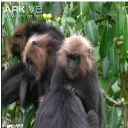

In [8]:
cv2_imshow(images[5])

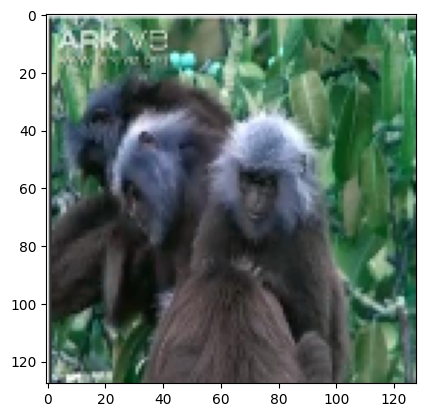

In [9]:
plt.imshow(images[5])

- We can observe that the images are being shown in different colors when plotted with openCV and matplotlib as OpenCV reads images in BGR format and this shows that the given numpy arrays were generated from the original images using OpenCV.
- Now we will convert these BGR images to RGB images so we could interpret them easily.

In [10]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

## **Exploratory Data Analysis**

In [11]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

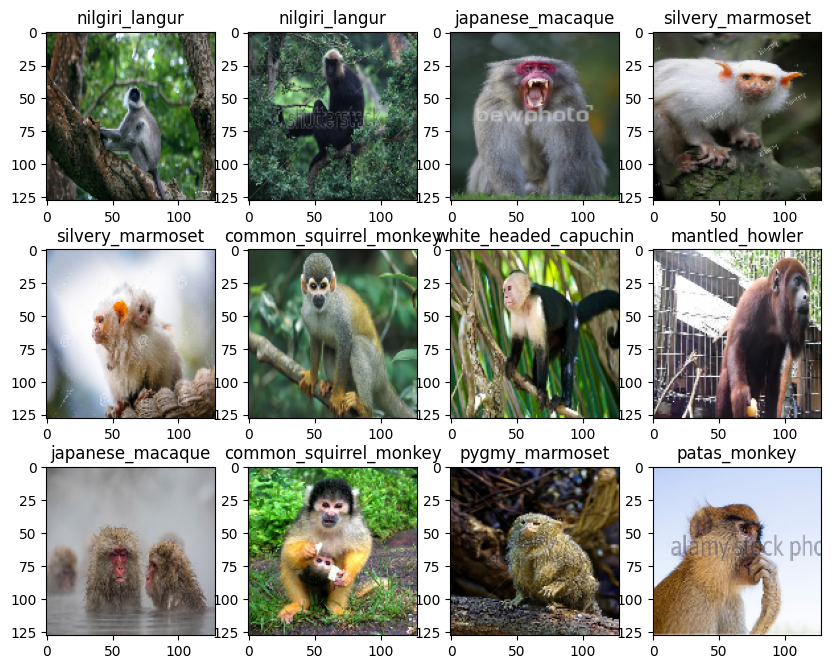

In [12]:
plot_images(images,labels)

<b> Checking for data imbalance

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 [Text(0.0, 0, '0'),
  Text(20.0, 0, '20'),
  Text(40.0, 0, '40'),
  Text(60.0, 0, '60'),
  Text(80.0, 0, '80'),
  Text(100.0, 0, '100'),
  Text(120.0, 0, '120'),
  Text(140.0, 0, '140'),
  Text(160.0, 0, '160')])

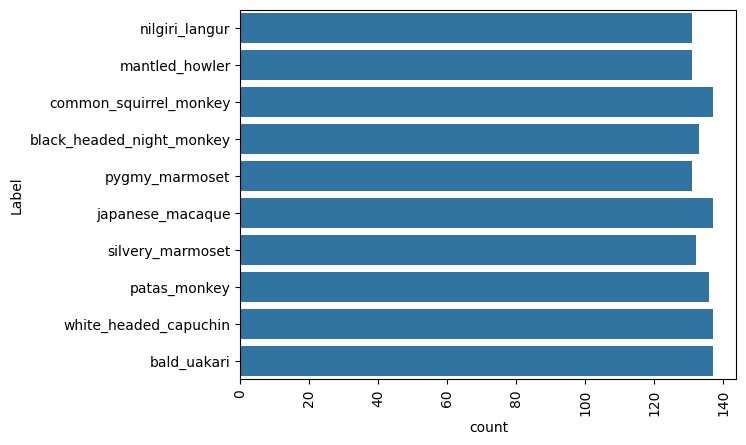

In [13]:
 sns.countplot(labels['Label'])
 plt.xticks(rotation='vertical')

- As you can see from the above plot, the dataset is quite balanced.
- There are about 135 images in each category

### Resizing images
As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [14]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

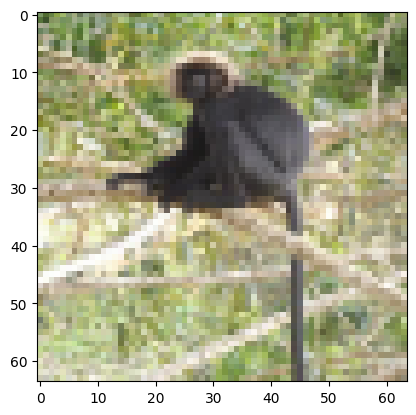

In [15]:
plt.imshow(images_decreased[3])

## Visualizing images using Gaussian Blur

In [16]:
# Applying Gaussian Blur to denoise the images
images_gb=[]
for i in range(len(images)):
  # gb[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
  images_gb.append(cv2.GaussianBlur(images[i], ksize =(3,3),sigmaX =  0))


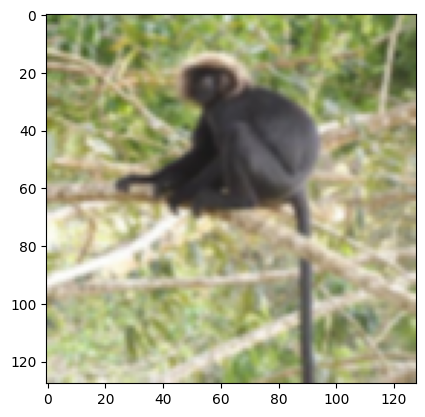

In [17]:
plt.imshow(images_gb[3])

- It appears that GaussianBlur would be ineffective because the blurred or denoised image does not seem to contain any relevant information, and the model would struggle to categorize these blurred images.

## **Splitting the dataset**

- As we have less images in our dataset, we will only use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.
- We are using the train_test_split() function from scikit-learn. Here, we split the dataset into three parts, train,test and validation.


In [18]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)


In [19]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(1086, 64, 64, 3) (1086, 1)
(121, 64, 64, 3) (121, 1)
(135, 64, 64, 3) (135, 1)


## **Making the data compatible:**

- Convert labels from names to one hot vectors
- Normalizing the values


## Encoding the target labels

In [20]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

## Data Normalization
Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [21]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0


## **Model Building - Convolutional Neural Network (CNN)**
Let's create a CNN model sequentially, where we will be adding the layers one after another.

First, we need to clear the previous model's history from the session even if a single model can run multiple times on the same data.

In Keras, we need a special command to clear the model's history, otherwise the previous model history remains in the backend.

Also, let's fix the seed again after clearing the backend.

Let's **set the seed for random number generators in Numpy, the Random library in Python, and in TensorFlow** to be able to reproduce the same results every time we run the code.

In [22]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [23]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Now, let's build a **CNN Model** with the following 2 main parts - <br>

1. **The Feature Extraction layers** which are comprised of convolutional and pooling layers.
2. **The Fully Connected classification layers** for prediction.<br><br>


In [24]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(10, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │         131,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 151,514 (591.85 KB)

 Trainable params: 151,514 (591.85 KB)

 Non-trainable params: 0 (0.00 B)

### <b> Fitting the model on the train data

In [25]:
history_1 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
34/34 - 15s - 428ms/step - accuracy: 0.1409 - loss: 2.2958 - val_accuracy: 0.1240 - val_loss: 2.2532
Epoch 2/30
34/34 - 0s - 6ms/step - accuracy: 0.1860 - loss: 2.2465 - val_accuracy: 0.1983 - val_loss: 2.1813
Epoch 3/30
34/34 - 0s - 9ms/step - accuracy: 0.2320 - loss: 2.1039 - val_accuracy: 0.2975 - val_loss: 2.0367
Epoch 4/30
34/34 - 0s - 6ms/step - accuracy: 0.2689 - loss: 1.9683 - val_accuracy: 0.3719 - val_loss: 1.9167
Epoch 5/30
34/34 - 0s - 6ms/step - accuracy: 0.3333 - loss: 1.8427 - val_accuracy: 0.3802 - val_loss: 1.8247
Epoch 6/30
34/34 - 0s - 9ms/step - accuracy: 0.3840 - loss: 1.6893 - val_accuracy: 0.3058 - val_loss: 1.8626
Epoch 7/30
34/34 - 0s - 8ms/step - accuracy: 0.3969 - loss: 1.6650 - val_accuracy: 0.3802 - val_loss: 1.7048
Epoch 8/30
34/34 - 0s - 9ms/step - accuracy: 0.4217 - loss: 1.5810 - val_accuracy: 0.4298 - val_loss: 1.7006
Epoch 9/30
34/34 - 0s - 9ms/step - accuracy: 0.4761 - loss: 1.4479 - val_accuracy: 0.4215 - val_loss: 1.6566
Epoch 10/30
34/3

### **Model Evaluation**

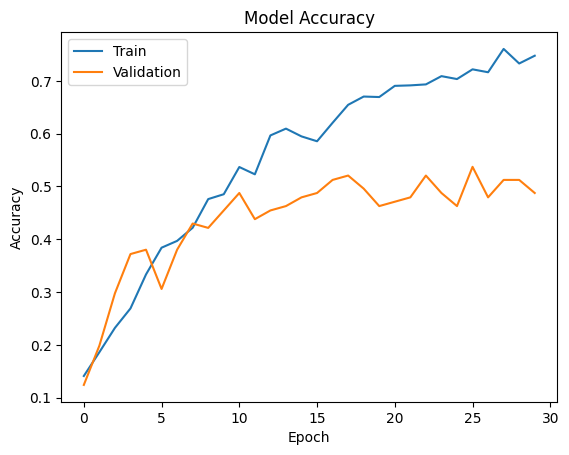

In [26]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:**


*   We can see from the above plot that **the training accuracy of the  model was good but the validation accuracy was not good.**
*   The model seems to overfit on the data.






### **Evaluating the model on train data**

In [27]:
accuracy = model.evaluate(X_train_normalized, y_train_encoded, verbose=2)

34/34 - 1s - 18ms/step - accuracy: 0.9687 - loss: 0.2100


### **Evaluating the model on validation data**

In [28]:

accuracy = model.evaluate(X_val_normalized,y_val_encoded, verbose=2)

4/4 - 0s - 8ms/step - accuracy: 0.4876 - loss: 2.0880


### **Evaluating the model on test data**

In [29]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

5/5 - 1s - 157ms/step - accuracy: 0.5481 - loss: 2.1261


### **Generating the predictions using test data**

In [30]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


In [31]:
y_pred

array([[6.08651061e-03, 7.73461461e-01, 4.83319117e-03, ...,
        9.53442901e-02, 1.16992295e-02, 1.93199469e-03],
       [5.03068604e-03, 8.28206157e-06, 5.99893901e-05, ...,
        7.37698167e-04, 3.74602416e-04, 2.37292388e-05],
       [9.99999166e-01, 3.00110245e-14, 4.79095604e-07, ...,
        9.95252880e-10, 6.71543246e-12, 1.16646115e-17],
       ...,
       [1.59871543e-05, 1.50119330e-08, 2.22319395e-05, ...,
        1.60056752e-05, 3.23206950e-05, 1.40829779e-05],
       [7.25384802e-03, 1.86125543e-02, 4.80127633e-02, ...,
        2.37812810e-02, 1.64347231e-01, 2.83647090e-01],
       [1.56027127e-05, 4.44432907e-03, 1.20840370e-04, ...,
        4.12837556e-03, 9.82097507e-01, 5.90328546e-03]], dtype=float32)

### **Plotting the Confusion Matrix**

*   The Confusion matrix is also defined as an inbuilt function in the TensorFlow module, so we can use that for evaluating the classification model.
*   The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,we must retrieve the categorical values from the encoded values.
*   We will use the `argmax()` function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.





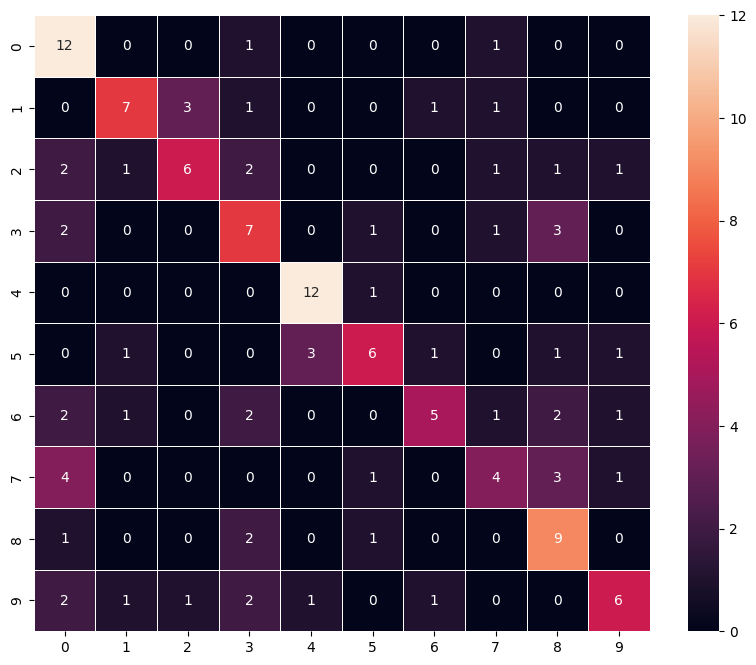

In [32]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

<b> Observations</b><br>
- We observe that some of the classes are not predicted correctly.
- In comparison to the rest, we can see that classes 0,3, and 4 are well classified.
- We can also observe that classes 1,2,5,7 and 9 are mostly misclassified.

# Model-2

As we can see, our initial model appears to overfit. Therefore we'll try to address this problem with data augmentation and Batch Normalization to check if we can improve the model's performance.

## **Data Augmentation**

In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs. To overcome this problem, one approach we might consider is **Data Augmentation**. CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. <br> Taking this attribute into account, we can augment the images using the techniques listed below - <br>
**1. Horizontal Flip** (should be set to True/False) <br>
**2. Vertical Flip** (should be set to True/False) <br>
**3. Height Shift** (should be between 0 and 1) <br>
**4. Width Shift** (should be between 0 and 1) <br>
**5. Rotation** (should be between 0 and 180) <br>
**6. Shear** (should be between 0 and 1) <br>
**7. Zoom** (should be between 0 and 1) etc. <br>

Remember, **data augmentation should not be used in the validation/test data set**.

In [33]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [34]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )
# test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

In [35]:
# Intializing a sequential model
model1 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))
# model.add(BatchNormalization())
model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))
model1.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model1.add(Dense(10, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │         131,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 151,642 (592.35 KB)

 Trainable params: 151,578 (592.10 KB)

 Non-trainable params: 64 (256.00 B)

In [36]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

history = model1.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 316ms/step - accuracy: 0.1512 - loss: 2.3995 - val_accuracy: 0.1818 - val_loss: 2.2728
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2500 - loss: 2.0929 - val_accuracy: 0.2066 - val_loss: 2.2664
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.2679 - loss: 2.0503 - val_accuracy: 0.2727 - val_loss: 2.2465
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2656 - loss: 1.9528 - val_accuracy: 0.2727 - val_loss: 2.2414
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.3398 - loss: 1.8531 - val_accuracy: 0.1818 - val_loss: 2.2531
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3906 - loss: 1.6778 - val_accuracy: 0.1983 - val_loss: 2.2535
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.4082 - loss: 1.6747 - val_accuracy: 0.2893 - val_loss: 2.2225
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3438 - loss: 1.8777 - val_accuracy: 0.2810 - val_

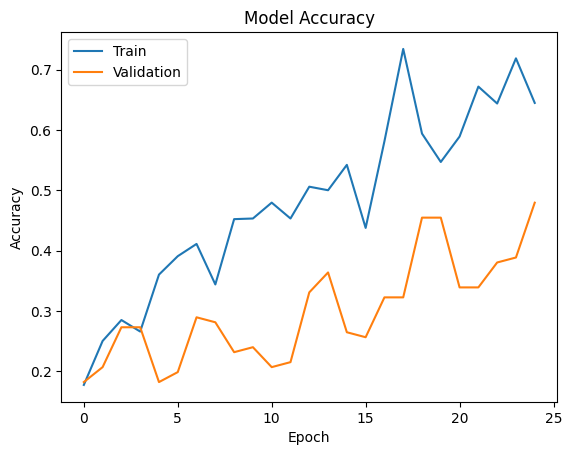

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### **Evaluating the model on train data**

In [38]:
accuracy = model1.evaluate(X_train_normalized, y_train_encoded, verbose=2)

34/34 - 1s - 16ms/step - accuracy: 0.6225 - loss: 1.6954


### **Evaluating the model on validation data**

In [39]:
accuracy = model1.evaluate(X_val_normalized,y_val_encoded, verbose=2)

4/4 - 0s - 8ms/step - accuracy: 0.4793 - loss: 1.8528


### **Evaluating the model on test data**

In [40]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

5/5 - 1s - 128ms/step - accuracy: 0.5111 - loss: 1.8174


We can observe that our accuracy has not improved compared to our previous model.

In [41]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


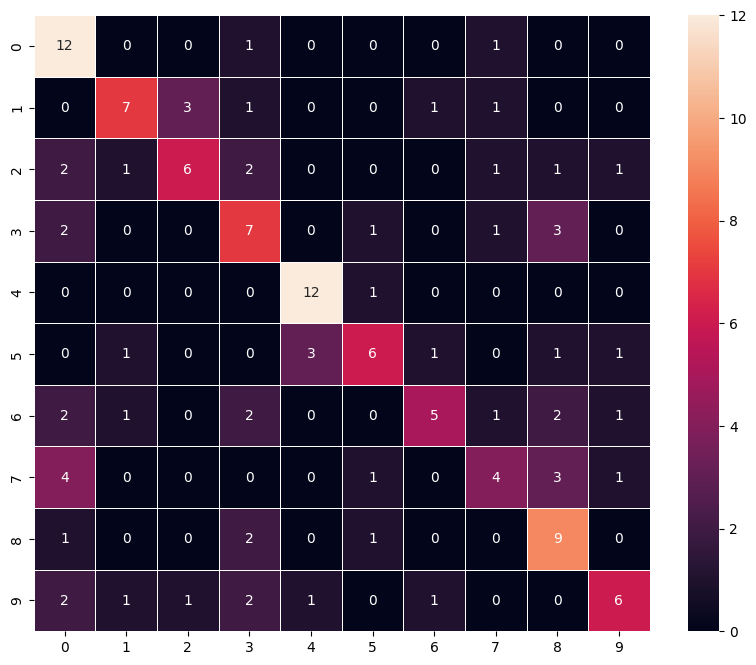

In [42]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

**Observation:**
- The confusion matrix appears to be not improving as well.
- The 7th class is the most confused class among all.
- We can observe that this model has not outperformed our previous model.

# Transfer Learning using VGG16

- Let's try again, but this time, we will be using the idea of **Transfer Learning**. We will be loading a pre-built architecture - **VGG16**, which was trained on the ImageNet dataset and is the runner-up in the ImageNet competition in 2014.

- For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, we will replace the existing fully-connected layers with FC layers created specifically for our problem.


In [43]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [45]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(32, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(16, activation='relu'))
new_model.add(Dense(10, activation='softmax'))
# Define the input shape for the new_model
# This is necessary to define the shape of the output of vgg_model
new_model.build(input_shape=(None, 64, 64, 3))
opt=Adam()
# Compile model
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 2, 2, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │          65,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,780,954 (56.38 MB)

 Trainable params: 66,266 (258.85 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [46]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

history_vgg16 = new_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 774ms/step - accuracy: 0.0859 - loss: 2.3479 - val_accuracy: 0.1570 - val_loss: 2.2525
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0938 - loss: 2.2758 - val_accuracy: 0.1570 - val_loss: 2.2486
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.1843 - loss: 2.2257 - val_accuracy: 0.2314 - val_loss: 2.1431
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1719 - loss: 2.2091 - val_accuracy: 0.2314 - val_loss: 2.1446
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.2440 - loss: 2.1269 - val_accuracy: 0.2975 - val_loss: 2.0273
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2500 - loss: 2.0046 - val_accuracy: 0.2893 - val_loss: 2.0216
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.2569 - loss: 2.0334 - val_accuracy: 0.3802 - val_loss: 1.9727
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2969 - loss: 1.9807 - val_accuracy: 0.3802 - val

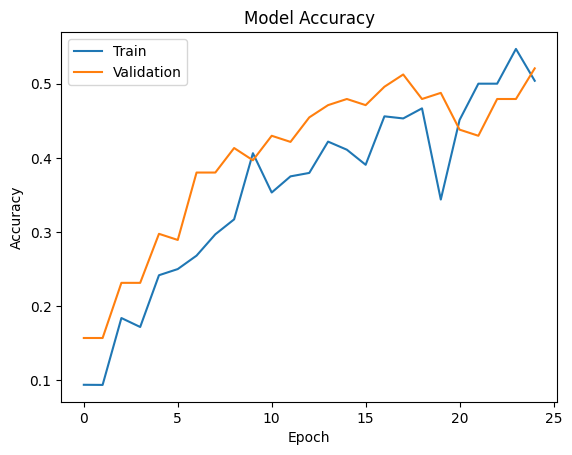

In [47]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### **Evaluating the model on train data**

In [48]:
accuracy = new_model.evaluate(X_train_normalized, y_train_encoded, verbose=2)

34/34 - 3s - 86ms/step - accuracy: 0.6252 - loss: 1.2681


### **Evaluating the model on validation data**

In [49]:
accuracy = new_model.evaluate(X_val_normalized,y_val_encoded, verbose=2)

4/4 - 0s - 23ms/step - accuracy: 0.5207 - loss: 1.5414


### **Evaluating the model on test data**

In [50]:
accuracy = new_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

5/5 - 2s - 356ms/step - accuracy: 0.4815 - loss: 1.5717


In [51]:
# Here we would get the output as probablities for each category
y_pred=new_model.predict(X_test_normalized)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


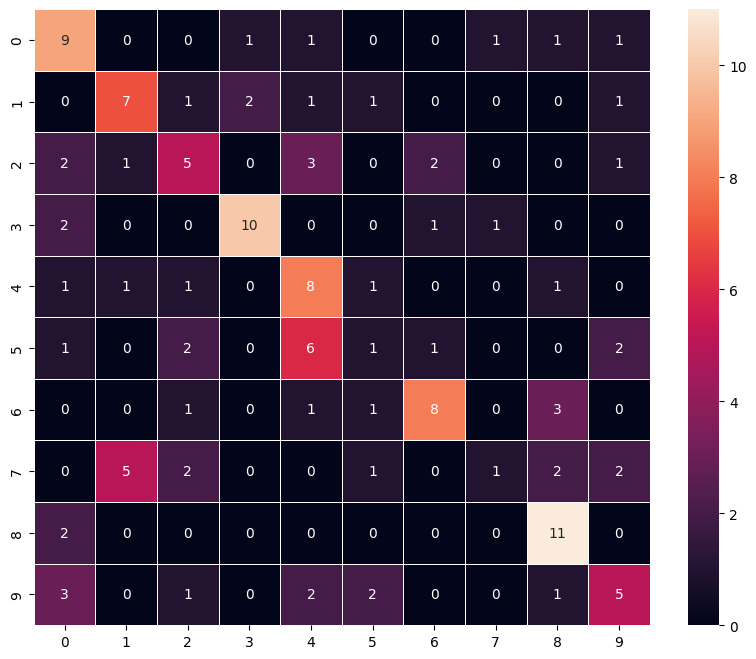

In [52]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

- According to the confusion matrix and accuracy curve, the VGG16 model has outperformed Model-2 but its test accuracy is lower than that of Base CNN model.

## **Visualizing the prediction:**

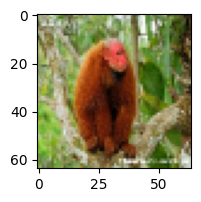

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Label ['bald_uakari']
True Label bald_uakari


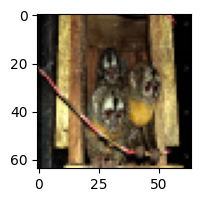

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Label ['black_headed_night_monkey']
True Label black_headed_night_monkey


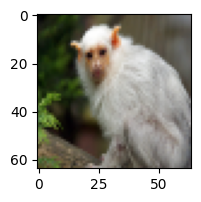

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Label ['silvery_marmoset']
True Label silvery_marmoset


In [53]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

## Conclusion
- We can observe from the confusion matrix of all the models that our Base CNN Model model was the best model because it predicted the majority of the classes better than the other models.
- The test accuracy of the Base CNN Model model is 52%.
- Data Augmentation has also helped in improving the model.
- Simply employing the Base CNN Model model can produce a better outcome than any CNN techniques.

In [54]:
pd.DataFrame({'Models':['Base CNN Model','CNN Model with Data Augmentation','Transfer Learning Model'],'Train Accuracy':['95%','66%','63%'],'Validation Accuracy':['47%','42%','52%'],'Test Accuracy':['52%','42%','48%']})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,Base CNN Model,95%,47%,52%
1,CNN Model with Data Augmentation,66%,42%,42%
2,Transfer Learning Model,63%,52%,48%


## Scope of Improvement
- These models can be further improved by training with different filter sizes and different number of filters.
- These models can also be trained on the original image_size i.e 128 x 128 rather than being reduced to 64.
- Data Augmentation can be performed more and dropout_rate can be changed to improve the model performance.
- Other Transfer Learning architectures can also be used to train the CNN model and these models can be used for classification.

# **Save the VGG16 Model**

In [57]:
model.save('my_model.keras')

In [58]:
from google.colab import files

# For TensorFlow/Keras
files.download('my_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>